In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import tqdm
import json
import pickle
from tqdm import tqdm
from copy import deepcopy
import itertools
import matplotlib.pyplot as plt

In [2]:
# Represents the semantic of each index in the match dataframe
with open('./categorical_ids.json', 'rb') as f:
    categorical_ids = json.load(f)

In [3]:
# Define a dictionary which inverts the categorical ids
# Ex) categorical_ids : Key -> Item
#    invs_categorical_ids : Item -> Key

invs_categorical_ids = {}

for k, v in categorical_ids.items():
    invs_categorical_ids[k] = {vv : kk for kk, vv in categorical_ids[k].items()}

In [4]:
# Represents the semantic of each column in the match dataframe
with open('./feature_to_array_idx.json', 'rb') as f:
    feature_to_array_idx = json.load(f)

In [5]:
# Train Dataset
train_match = pd.read_csv('train.csv')

In [6]:
# User history 
user_history = np.load('user_history.npy')

In [7]:
with open('./RIOT_API_info.json', 'rb') as f:
    champion_riot_api_idx = json.load(f)

# Validate whether there are any faulty matches

In [8]:
num_train = len(train_match)

blue_team = [0,3,4,7,8]
red_team = [1,2,5,6,9]

for i in tqdm(range(num_train)):
    match = train_match.iloc[i]
    user_role_list = []
    
    check_blue_team_roles = set(['TOP', 'JUNGLE', 'MIDDLE', 'DUO_CARRY', 'DUO_SUPPORT'])
    check_red_team_roles = set(['TOP', 'JUNGLE', 'MIDDLE', 'DUO_CARRY', 'DUO_SUPPORT'])
    
    for i in range(10):
        user_idx = 'User' + str(i+1)
        user_id, history_num = eval(match[user_idx])
        user_role = user_history[user_id][history_num][feature_to_array_idx['role'][0]:feature_to_array_idx['role'][1]]
        user_role_list.append(invs_categorical_ids['role'][int(user_role.item())])
        
    blue_team_roles = set([user_role_list[i] for i in blue_team])
    red_team_roles = set([user_role_list[i] for i in red_team])

    # Check whether all roles are present in the dataset
    if (check_blue_team_roles - blue_team_roles) != set():
        raise AssertionError
    elif (blue_team_roles - check_blue_team_roles) != set():
        raise AssertionError
    elif (check_red_team_roles - red_team_roles) != set():
        raise AssertionError
    elif (red_team_roles - check_red_team_roles) != set():
        raise AssertionError
    
print('No Error Found')

100%|█████████████████████████████████| 236408/236408 [02:51<00:00, 1381.93it/s]

No Error Found


# Check whether the lanes were 'appropriately' given

In [9]:
def create_champ_role_matrix(dataset, user_history,num_participants):
    
    num_train = len(dataset)
    
    user_champion_list = []
    user_role_list = []
    user_win_list = []
    
    for i in tqdm(range(num_train)):
        
        match = dataset.iloc[i]
        
        for i in range(num_participants):
            user_idx = 'User' + str(i+1)
            user_id, history_num = eval(match[user_idx])
            
            user_champion = user_history[user_id][history_num][feature_to_array_idx['champion'][0]:feature_to_array_idx['champion'][1]]
            user_champion_list.append(int(user_champion.item()))
            
            user_role = user_history[user_id][history_num][feature_to_array_idx['role'][0]:feature_to_array_idx['role'][1]]
            user_role_list.append(int(user_role.item()))
            
            user_win = user_history[user_id][history_num][feature_to_array_idx['win'][0]:feature_to_array_idx['win'][1]]
            user_win_list.append(int(user_win.item()))
    
    np_champion = np.array(user_champion_list)
    np_role = np.array(user_role_list)
    np_win = np.array(user_win_list)
    
    return np_champion, np_role, np_win

In [10]:
train_champion, train_role, train_win = create_champ_role_matrix(train_match, user_history,10)

100%|█████████████████████████████████| 236408/236408 [02:58<00:00, 1324.54it/s]


In [11]:
def make_champion_id2name_dict(champion_name_info):
    
    champion_id2name_dict = {}
    
    for champion_name in champion_name_info.keys():
        key = champion_name_info[champion_name]['key']
        champion_id2name_dict[key] = champion_name
    
    return champion_id2name_dict

In [12]:
champion_id2name_dict = make_champion_id2name_dict(champion_riot_api_idx['data'])

In [13]:
def create_champion_dict(train_champion, train_role, train_win, champion_id2name_dict):
    
    train_champion_dict = {'role' : {}, 'win' : {}}
    
    for i in tqdm(range(train_champion.shape[0])):
        champ_idx = train_champion[i]
        champ_idx = invs_categorical_ids['champion'][champ_idx]
        champ_name = champion_id2name_dict[champ_idx]
        
        win_idx = train_win[i]       
        role_idx = train_role[i]
        
        if champ_name not in train_champion_dict['role']:
            train_champion_dict['role'][champ_name] = {}
            for j in categorical_ids['role'].keys():
                train_champion_dict['role'][champ_name][j] = 0
                
        if champ_name not in train_champion_dict['win']:
            train_champion_dict['win'][champ_name] = {}
            for j in categorical_ids['win'].keys():
                train_champion_dict['win'][champ_name][j] = 0
                
                
        role_name = invs_categorical_ids['role'][role_idx]
        train_champion_dict['role'][champ_name][role_name] += 1
        
        user_win = invs_categorical_ids['win'][win_idx]
        train_champion_dict['win'][champ_name][user_win] += 1
        
    for i in train_champion_dict['role'].keys():
        sum = 0
        for j in train_champion_dict['role'][i].keys():
            sum += train_champion_dict['role'][i][j]
        train_champion_dict['role'][i]['sum'] = sum
        for j in train_champion_dict['role'][i].keys():
            if j == 'sum':
                continue
            train_champion_dict['role'][i][j] = train_champion_dict['role'][i][j] / sum
            
    for i in train_champion_dict['win'].keys():
        sum = 0
        for j in train_champion_dict['win'][i].keys():
            sum += train_champion_dict['win'][i][j]
        train_champion_dict['win'][i]['sum'] = sum
        for j in train_champion_dict['win'][i].keys():
            if j == 'sum':
                continue
            train_champion_dict['win'][i][j] = train_champion_dict['win'][i][j] / sum
            
            
    # Remove unnecessary information from the dictionary
    for key in train_champion_dict.keys():
        for champion in train_champion_dict[key].keys():
            train_champion_dict[key][champion].pop('PAD')
            train_champion_dict[key][champion].pop('MASK')
            train_champion_dict[key][champion].pop('CLS')
            train_champion_dict[key][champion].pop('UNK')
    
    return train_champion_dict

In [14]:
train_champion_dict = create_champion_dict(train_champion, train_role, train_win,champion_id2name_dict)

100%|█████████████████████████████| 2364080/2364080 [00:09<00:00, 238056.67it/s]


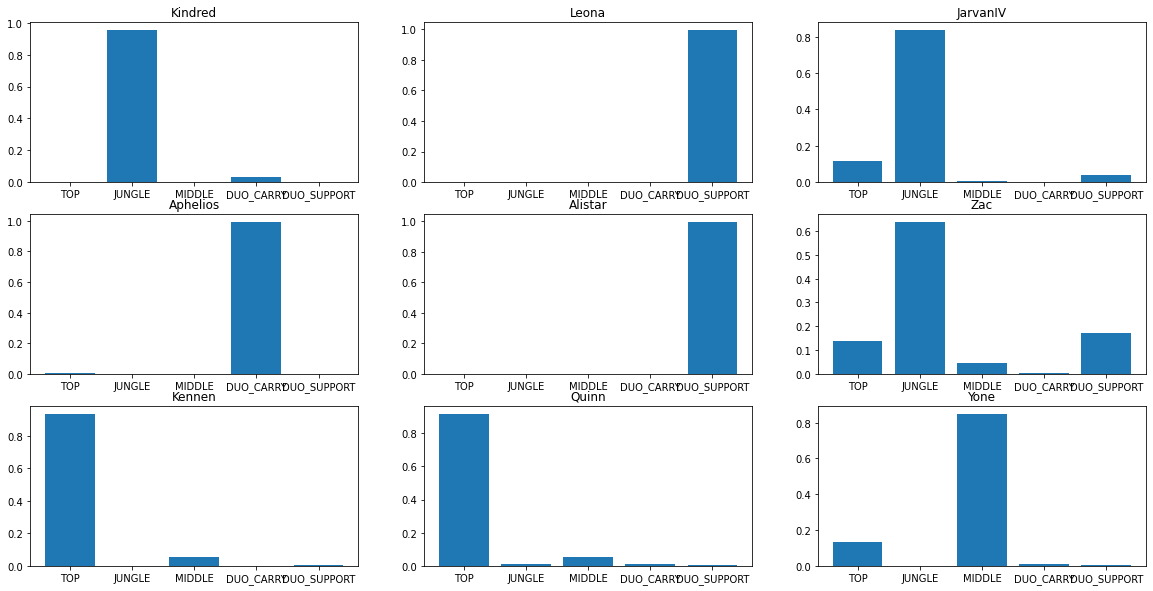

In [15]:
figure, axes = plt.subplots(3,3, figsize=(20,10))
champion_names = [champion_name for champion_name in train_champion_dict['role'].keys()]

for i in range(3):
    for d in range(3):
        champion_role_dict = deepcopy(train_champion_dict['role'][champion_names[(i*3)+d]])
        champion_role_dict.pop('sum')
        axes[i,d].bar(champion_role_dict.keys(), champion_role_dict.values())
        axes[i,d].set_title(champion_names[(i*3)+d])


In [16]:
train_champion_dict['win']['Amumu']

{'Fail': 0.6234132581100141, 'Win': 0.3765867418899859, 'sum': 709}

In [17]:
# Explains the role each champions were given according to the statistics
train_champion_dict['role']['Ahri']

{'TOP': 0.009423150388386604,
 'JUNGLE': 0.00025467974022666496,
 'MIDDLE': 0.9803896600025468,
 'DUO_CARRY': 0.0021647777919266524,
 'DUO_SUPPORT': 0.007767732076913282,
 'sum': 7853}

In [18]:
# 'train_champion_win_rate.json' and 'train_champion_role_rate.json' provides win rate and role ratio information for each champion

with open('./train_champion_win_rate.json', 'w') as f:
    json.dump(train_champion_dict['win'], f)
    
with open('./train_champion_role_ratio.json', 'w') as f:
    json.dump(train_champion_dict['role'], f)

# Champions with the highest and lowest win rate

In [19]:
champion_win_rate_dict = {k : v['Win'] for k, v in train_champion_dict['win'].items()}
champion_win_rate_df = round(pd.DataFrame.from_dict(champion_win_rate_dict, orient='index', columns = ['Win rate']), 3)

high_champion_win_rate_df = champion_win_rate_df.sort_values(by= ['Win rate'], ascending=False)
#print("5 Top highest win rate champion list")
high_champion_win_rate_df = high_champion_win_rate_df.head().style.set_table_attributes("style='display:inline'").set_caption('Top 5 champions with highest win rate')
display(high_champion_win_rate_df)

low_champion_win_rate_df = champion_win_rate_df.sort_values(by= ['Win rate'], ascending=True)
low_champion_win_rate_df = low_champion_win_rate_df.head().style.set_table_attributes("style='display:inline'").set_caption('Top 5 champions with lowest win rate')
display(low_champion_win_rate_df)

,Win rate
AurelionSol,0.542000
Karthus,0.542000
Skarner,0.532000
Bard,0.532000
Ziggs,0.527000


,Win rate
Amumu,0.377000
Udyr,0.436000
MasterYi,0.436000
Yuumi,0.456000
Akali,0.458000


<AxesSubplot:ylabel='Frequency'>

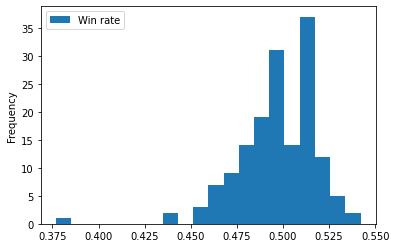

In [20]:
champion_win_rate_df.plot.hist(bins=20)

# Champions with the most frequent appearances

In [21]:
champion_frequency_dict = {k : v['sum'] for k, v in train_champion_dict['win'].items()}
champion_frequency_df = pd.DataFrame.from_dict(champion_frequency_dict, orient='index', columns = ['Frequency by appearance'])
champion_frequency_df = round((champion_frequency_df / champion_frequency_df.sum() * 100), 3)

In [22]:
high_champion_frequency_df = champion_frequency_df.sort_values(by= ['Frequency by appearance'], ascending=False)
high_champion_frequency_df = high_champion_frequency_df.head().style.set_table_attributes("style='display:inline'").set_caption('Top 5 champions with highest frequency')
display(high_champion_frequency_df)

low_champion_frequency_df = champion_frequency_df.sort_values(by= ['Frequency by appearance'], ascending=True)
low_champion_frequency_df = low_champion_frequency_df.head().style.set_table_attributes("style='display:inline'").set_caption('Top 5 champions with lowest frequency')
display(low_champion_frequency_df)

,Frequency by appearance
LeeSin,3.631000
Ezreal,3.469000
Thresh,2.515000
Viego,2.387000
Aphelios,2.235000


,Frequency by appearance
Amumu,0.030000
Illaoi,0.052000
Yorick,0.053000
Udyr,0.055000
Chogath,0.055000


# Scatter plot champions' win rate and appearance frequency

In [23]:
champion_scatter_plot_df = pd.concat([champion_win_rate_df,champion_frequency_df], axis=1)

In [24]:
champion_scatter_plot_df

,Win rate,Frequency by appearance
Kindred,0.511,0.891
Leona,0.509,1.697
JarvanIV,0.494,0.686
Aphelios,0.496,2.235
Alistar,0.496,0.811
...,...,...
Shyvana,0.483,0.069
Singed,0.511,0.189
Udyr,0.436,0.055
Illaoi,0.518,0.052


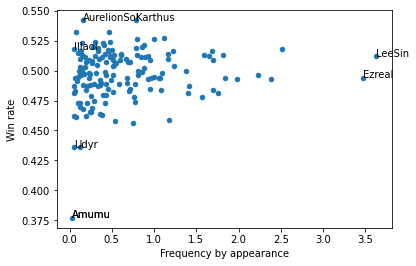

In [25]:
ax = champion_scatter_plot_df.plot.scatter(x='Frequency by appearance', y='Win rate')

high_freq_champions = champion_scatter_plot_df.loc[high_champion_frequency_df.index[:2]]
for k in range(len(high_freq_champions)):
    freq = high_freq_champions.loc[high_freq_champions.index[k]]['Frequency by appearance']
    win = high_freq_champions.loc[high_freq_champions.index[k]]['Win rate']
    ax.text(freq, win, high_freq_champions.index[k])

low_freq_champions = champion_scatter_plot_df.loc[low_champion_frequency_df.index[:2]]
for k in range(len(low_freq_champions)):
    freq = low_freq_champions.loc[low_freq_champions.index[k]]['Frequency by appearance']
    win = low_freq_champions.loc[low_freq_champions.index[k]]['Win rate']
    ax.text(freq, win, low_freq_champions.index[k])
    
high_win_champions = champion_scatter_plot_df.loc[high_champion_win_rate_df.index[:2]]
for k in range(len(high_win_champions)):
    freq = high_win_champions.loc[high_win_champions.index[k]]['Frequency by appearance']
    win = high_win_champions.loc[high_win_champions.index[k]]['Win rate']
    ax.text(freq, win, high_win_champions.index[k])

low_win_champions = champion_scatter_plot_df.loc[low_champion_win_rate_df.index[:2]]
for k in range(len(low_win_champions)):
    freq = low_win_champions.loc[low_win_champions.index[k]]['Frequency by appearance']
    win = low_win_champions.loc[low_win_champions.index[k]]['Win rate']
    ax.text(freq, win, low_win_champions.index[k])

# Which team has an advantage

In [26]:
def team_win_count_dict(dataset_df, user_history,feature_to_array_idx, categorical_ids, invs_categorical_ids):
    
    team_win_count_dict = {}
    
    # Initialize the tean win rate dictionary
    for k in categorical_ids['team'].keys():
        team_win_count_dict[k] = 0
    
    num_matches = len(dataset_df)
    
    for match_idx in tqdm(range(num_matches)):
        
        match = dataset_df.iloc[match_idx]
        
        for i in range(10):
            user_idx = 'User' + str(i+1)
            user_id, history_num = eval(match[user_idx])
            user_team = user_history[user_id][history_num][feature_to_array_idx['team'][0]:feature_to_array_idx['team'][1]]
            user_team = invs_categorical_ids['team'][int(user_team.item())]
            
            user_win = user_history[user_id][history_num][feature_to_array_idx['win'][0]:feature_to_array_idx['win'][1]]
            
            if user_win == categorical_ids['win']['Win']:
                if user_team in team_win_count_dict.keys():
                    team_win_count_dict[user_team] += 1
                else:
                    raise AssertionError
    
    
    # Remove unnecessary information from the dictionary
    team_win_count_dict.pop('PAD')
    team_win_count_dict.pop('MASK')
    team_win_count_dict.pop('CLS')
    team_win_count_dict.pop('UNK')
    
    return team_win_count_dict

In [27]:
team_win_count_dict = team_win_count_dict(train_match, user_history, feature_to_array_idx, categorical_ids, invs_categorical_ids)

100%|█████████████████████████████████| 236408/236408 [03:17<00:00, 1197.27it/s]


In [28]:
blue_team_win_rate = team_win_count_dict['BLUE'] / (team_win_count_dict['BLUE'] + team_win_count_dict['RED'])
red_team_win_rate = team_win_count_dict['RED'] / (team_win_count_dict['BLUE'] + team_win_count_dict['RED'])

print("Blue team win rate is : {:.2%}".format(blue_team_win_rate))
print("Red team win rate is : {:.2%}".format(red_team_win_rate))

Blue team win rate is : 50.38%
Red team win rate is : 49.62%


# Visualize the champion pairs with the highest and lowest win rate

In [29]:
def create_champion_pair_dict(dataset_df, user_history,feature_to_array_idx, categorical_ids, invs_categorical_ids, champion_id2name_dict):
    
    champion_categorical_ids = deepcopy(categorical_ids['champion'])
    champion_categorical_ids.pop('PAD')
    champion_categorical_ids.pop('MASK')
    champion_categorical_ids.pop('CLS')
    champion_categorical_ids.pop('UNK')

    new_champion_categorical_ids = {}
    for key, value in champion_categorical_ids.items():
        champion_name = champion_id2name_dict[key]
        new_champion_categorical_ids[champion_name] = value
    
    # Initialize the champion pair dictionary
    champion_pair_dict = {}

    for champ_name1 in  tqdm(new_champion_categorical_ids.keys()):
        for champ_name2 in new_champion_categorical_ids.keys():
            # Don't include a champion pair against itself
            if champ_name1 == champ_name2:
                continue
            # Don't include the champion pair if it has already been included in the dictionary
            if (champ_name2, champ_name1) in champion_pair_dict.keys():
                continue
            else:
                champion_pair_dict[(champ_name1, champ_name2)] = {'count' : 0, 'win' : 0, 'lose' : 0}
    
    num_matches = len(dataset_df)
    blue_team = [0,3,4,7,8]
    red_team = [1,2,5,6,9]
    
    for match_idx in tqdm(range(num_matches)):
        
        match = dataset_df.iloc[match_idx]
        
        user_champion_list = []
        user_win_list = []
        for user_num in range(10):
            user_idx = 'User' + str(user_num+1)
            user_id, history_num = eval(match[user_idx])
            
            user_champion = user_history[user_id][history_num][feature_to_array_idx['champion'][0]:feature_to_array_idx['champion'][1]]
            user_champion = invs_categorical_ids['champion'][user_champion.item()]
            user_champion = champion_id2name_dict[user_champion]
            user_champion_list.append(user_champion)
            
            user_win = user_history[user_id][history_num][feature_to_array_idx['win'][0]:feature_to_array_idx['win'][1]]
            user_win_list.append(int(user_win.item()))

        blue_team_champions = [user_champion_list[idx] for idx in blue_team]
        red_team_champions = [user_champion_list[idx] for idx in red_team]
        
        if user_win_list[0] == categorical_ids['win']['Win']:
            blue_team_win = True
            red_team_win = False
        elif user_win_list[1] == categorical_ids['win']['Win']:
            blue_team_win = False
            red_team_win = True
        else:
            raise AssertionError
        
        blue_team_champion_pairs = itertools.combinations(blue_team_champions, 2)
        for champion_pair in blue_team_champion_pairs:
            champion1 = champion_pair[0]
            champion2 = champion_pair[1]
            
            if tuple([champion1, champion2]) in champion_pair_dict.keys():
                champion_pair_dict[tuple([champion1, champion2])]['count'] += 1
                if blue_team_win:
                    champion_pair_dict[tuple([champion1, champion2])]['win'] += 1
                else:
                    champion_pair_dict[tuple([champion1, champion2])]['lose'] += 1
            elif tuple([champion2, champion1]) in champion_pair_dict.keys():
                champion_pair_dict[tuple([champion2, champion1])]['count'] += 1
                if blue_team_win:
                    champion_pair_dict[tuple([champion2, champion1])]['win'] += 1
                else:
                    champion_pair_dict[tuple([champion2, champion1])]['lose'] += 1
            else:
                raise AssertionError

        red_team_champion_pairs = itertools.combinations(red_team_champions, 2)
        for champion_pair in red_team_champion_pairs:
            champion1 = champion_pair[0]
            champion2 = champion_pair[1]
            
            if tuple([champion1, champion2]) in champion_pair_dict.keys():
                champion_pair_dict[tuple([champion1, champion2])]['count'] += 1
                if red_team_win:
                    champion_pair_dict[tuple([champion1, champion2])]['win'] += 1
                else:
                    champion_pair_dict[tuple([champion1, champion2])]['lose'] += 1
            elif tuple([champion2, champion1]) in champion_pair_dict.keys():
                champion_pair_dict[tuple([champion2, champion1])]['count'] += 1
                if red_team_win:
                    champion_pair_dict[tuple([champion2, champion1])]['win'] += 1
                else:
                    champion_pair_dict[tuple([champion2, champion1])]['lose'] += 1
            else:
                raise AssertionError

    return champion_pair_dict

In [30]:
champion_pair_dict = create_champion_pair_dict(train_match, user_history,feature_to_array_idx, categorical_ids, invs_categorical_ids, champion_id2name_dict)

100%|█████████████████████████████████| 236408/236408 [02:57<00:00, 1331.12it/s]


In [31]:
#champion_pair_dict

In [32]:
champion_pair_win_rate_dict = {}
for key in champion_pair_dict.keys():
    if champion_pair_dict[key]['count'] > 1000:
        champion_pair_win_rate_dict[key] = champion_pair_dict[key]['win'] / champion_pair_dict[key]['count']

cnt  = 0
for k, v in champion_pair_win_rate_dict.items():
    if v > 0.5:
        cnt+=1
print("Number of champion combinations that have over 50% win rate with over 1000 appearances: ",cnt)
print("Number of total champion combinations with over 1000 appearances: ", len(champion_pair_win_rate_dict.keys()))

Number of champion combinations that have over 50% win rate with over 1000 appearances:  626
Number of total champion combinations with over 1000 appearances:  1173


In [33]:
champion_pair_win_rate_df = pd.DataFrame.from_dict(champion_pair_win_rate_dict, orient='index', columns = ['Win rate'])

high_champion_pair_win_rate_df = champion_pair_win_rate_df.sort_values(by= ['Win rate'], ascending=False)
#print("5 Top highest win rate champion list")
high_champion_pair_win_rate_df = high_champion_pair_win_rate_df.head().style.set_table_attributes("style='display:inline'").set_caption('Top 5 champion pairs with highest win rate')
display(high_champion_pair_win_rate_df)

low_champion_pair_win_rate_df = champion_pair_win_rate_df.sort_values(by= ['Win rate'], ascending=True)
low_champion_pair_win_rate_df = low_champion_pair_win_rate_df.head().style.set_table_attributes("style='display:inline'").set_caption('Top 5 champion pairs with lowest win rate')
display(low_champion_pair_win_rate_df)

,Win rate
"('Karthus', 'Qiyana')",0.586271
"('Jhin', 'Karthus')",0.575195
"('Talon', 'Maokai')",0.569154
"('Karthus', 'Talon')",0.567980
"('Kindred', 'Maokai')",0.565969


,Win rate
"('Jayce', 'Yuumi')",0.419263
"('Karma', 'Akali')",0.421715
"('Sylas', 'Yuumi')",0.424415
"('Irelia', 'Yuumi')",0.425662
"('Karma', 'Ryze')",0.428571


# Visualize the champion pairs with the highest and lowest appearance frequency

In [34]:
champion_pair_frequency_dict = {k : v['count'] for k, v in champion_pair_dict.items() if v['count']>1000}
champion_pair_frequency_df = pd.DataFrame.from_dict(champion_pair_frequency_dict, orient='index', columns = ['Frequency by appearance'])
champion_pair_frequency_df = round((champion_pair_frequency_df / champion_pair_frequency_df.sum() * 100), 3)

In [35]:
high_champion_pair_frequency_df = champion_pair_frequency_df.sort_values(by= ['Frequency by appearance'], ascending=False)
high_champion_pair_frequency_df = high_champion_pair_frequency_df.head().style.set_table_attributes("style='display:inline'").set_caption('Top 5 champion pairs with highest frequency')
display(high_champion_pair_frequency_df)

low_champion_pair_frequency_df = champion_pair_frequency_df.sort_values(by= ['Frequency by appearance'], ascending=True)
low_champion_pair_frequency_df = low_champion_pair_frequency_df.head().style.set_table_attributes("style='display:inline'").set_caption('Top 5 champion pairs with lowest frequency')
display(low_champion_pair_frequency_df)

,Frequency by appearance
"('Aphelios', 'Thresh')",0.676000
"('Ezreal', 'LeeSin')",0.599000
"('Karma', 'Ezreal')",0.572000
"('Thresh', 'LeeSin')",0.432000
"('Sylas', 'LeeSin')",0.425000


,Frequency by appearance
"('Renekton', 'Vayne')",0.042000
"('Ashe', 'TwistedFate')",0.042000
"('Lulu', 'Akshan')",0.042000
"('Thresh', 'Kassadin')",0.042000
"('Ekko', 'Pyke')",0.042000


# Scatter plot champion pair win rate and appearance frequency

In [36]:
champion_scatter_plot_df = pd.concat([champion_pair_win_rate_df,champion_pair_frequency_df], axis=1)

In [37]:
champion_scatter_plot_df

,Win rate,Frequency by appearance
"(Kindred, Aphelios)",0.504136,0.085
"(Kindred, Leona)",0.523068,0.072
"(Kindred, Kaisa)",0.489451,0.069
"(Kindred, Irelia)",0.483613,0.057
"(Kindred, Jayce)",0.462171,0.051
...,...,...
"(Viego, KogMaw)",0.496746,0.077
"(Viego, Viktor)",0.498736,0.049
"(Varus, Katarina)",0.501478,0.042
"(Varus, Nautilus)",0.473851,0.053


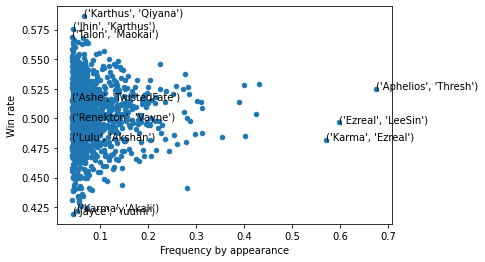

In [38]:
ax = champion_scatter_plot_df.plot.scatter(x='Frequency by appearance', y='Win rate')

high_freq_champions = champion_scatter_plot_df.loc[high_champion_pair_frequency_df.index[:3]]
for k in range(len(high_freq_champions)):
    freq = high_freq_champions.iloc[k]['Frequency by appearance']
    win = high_freq_champions.iloc[k]['Win rate']
    ax.text(freq, win, str(high_freq_champions.index[k]))

low_freq_champions = champion_scatter_plot_df.loc[low_champion_pair_frequency_df.index[:3]]
for k in range(len(low_freq_champions)):
    freq = low_freq_champions.iloc[k]['Frequency by appearance']
    win = low_freq_champions.iloc[k]['Win rate']
    ax.text(freq, win, str(low_freq_champions.index[k]))
    
high_win_champions = champion_scatter_plot_df.loc[high_champion_pair_win_rate_df.index[:3]]
for k in range(len(high_win_champions)):
    freq = high_win_champions.iloc[k]['Frequency by appearance']
    win = high_win_champions.iloc[k]['Win rate']
    ax.text(freq, win, str(high_win_champions.index[k]))

low_win_champions = champion_scatter_plot_df.loc[low_champion_pair_win_rate_df.index[:2]]
for k in range(len(low_win_champions)):
    freq = low_win_champions.iloc[k]['Frequency by appearance']
    win = low_win_champions.iloc[k]['Win rate']
    ax.text(freq, win, str(low_win_champions.index[k]))

# Visualize the Mid-Jungle champion pairs with the highest and lowest win rate

In [39]:
def create_champion_role_pair_dict(dataset_df, user_history,feature_to_array_idx, categorical_ids, invs_categorical_ids, champion_id2name_dict, train_champion_dict, champion_role_pair):
    
    champion_categorical_ids = deepcopy(categorical_ids['champion'])
    champion_categorical_ids.pop('PAD')
    champion_categorical_ids.pop('MASK')
    champion_categorical_ids.pop('CLS')
    champion_categorical_ids.pop('UNK')

    new_champion_categorical_ids = {}
    for key, value in champion_categorical_ids.items():
        champion_name = champion_id2name_dict[key]
        new_champion_categorical_ids[champion_name] = value
    
    # Initialize the champion pair dictionary
    champion_pair_dict = {}

    for champ_name1 in  tqdm(new_champion_categorical_ids.keys()):
        for champ_name2 in new_champion_categorical_ids.keys():
            # Don't include a champion pair against itself
            if champ_name1 == champ_name2:
                continue
            # Don't include the champion pair if it has already been included in the dictionary
            if (champ_name2, champ_name1) in champion_pair_dict.keys():
                continue
            else:
                champion_pair_dict[(champ_name1, champ_name2)] = {'count' : 0, 'win' : 0, 'lose' : 0}
    
    num_matches = len(dataset_df)
    blue_team = [0,3,4,7,8]
    red_team = [1,2,5,6,9]
    role_list = ['TOP', 'JUNGLE', 'MIDDLE', 'DUO_CARRY', 'DUO_SUPPORT']
    
    for match_idx in tqdm(range(num_matches)):
        
        match = dataset_df.iloc[match_idx]
        
        user_champion_list = []
        user_win_list = []
        user_role_list = []
        for user_num in range(10):
            user_idx = 'User' + str(user_num+1)
            user_id, history_num = eval(match[user_idx])
            
            user_champion = user_history[user_id][history_num][feature_to_array_idx['champion'][0]:feature_to_array_idx['champion'][1]]
            user_champion = invs_categorical_ids['champion'][user_champion.item()]
            user_champion = champion_id2name_dict[user_champion]
            user_champion_list.append(user_champion)
            
            user_win = user_history[user_id][history_num][feature_to_array_idx['win'][0]:feature_to_array_idx['win'][1]]
            user_win_list.append(int(user_win.item()))

            user_role = user_history[user_id][history_num][feature_to_array_idx['role'][0]:feature_to_array_idx['role'][1]]
            user_role = invs_categorical_ids['role'][user_role.item()]
            user_role_list.append(user_role)
            
        blue_team_champions = [user_champion_list[idx] for idx in blue_team]
        red_team_champions = [user_champion_list[idx] for idx in red_team]

        blue_team_roles = [user_role_list[idx] for idx in blue_team]
        red_team_roles = [user_role_list[idx] for idx in red_team]
        
        if user_win_list[0] == categorical_ids['win']['Win']:
            blue_team_win = True
            red_team_win = False
        elif user_win_list[1] == categorical_ids['win']['Win']:
            blue_team_win = False
            red_team_win = True
        else:
            raise AssertionError
        
        role1 = champion_role_pair[0]
        role2 = champion_role_pair[1]
        blue_role1_champion = None
        blue_role2_champion = None
        count_blue_team = True
        for idx, role in enumerate(blue_team_roles):
            if role == role1:
                blue_role1_champion = blue_team_champions[idx]
                # Check if the champion main role is actually 'MIDDLE'
                blue_role1_champion_role_dict = train_champion_dict['role'][blue_role1_champion]
                for role in role_list:
                    if blue_role1_champion_role_dict[role] > blue_role1_champion_role_dict[role1]:
                        count_blue_team = False
            elif role == role2:
                blue_role2_champion = blue_team_champions[idx]
                # Check if the champion main role is actually 'JUNGLE'
                blue_role2_champion_role_dict = train_champion_dict['role'][blue_role2_champion]
                for role in role_list:
                    if blue_role2_champion_role_dict[role] > blue_role2_champion_role_dict[role2]:
                        count_blue_team = False
            else:
                continue
                
        red_role1_champion = None
        red_role2_champion = None
        count_red_team = True
        for idx, role in enumerate(red_team_roles):
            if role == role1:
                red_role1_champion = red_team_champions[idx]
                # Check if the champion main role is actually 'MIDDLE'
                red_role1_champion_role_dict = train_champion_dict['role'][red_role1_champion]
                for role in role_list:
                    if red_role1_champion_role_dict[role] > red_role1_champion_role_dict[role1]:
                        count_red_team = False
            elif role == role2:
                red_role2_champion = red_team_champions[idx]
                # Check if the champion main role is actually 'JUNGLE'
                red_role2_champion_role_dict = train_champion_dict['role'][red_role2_champion]
                for role in role_list:
                    if red_role2_champion_role_dict[role] > red_role2_champion_role_dict[role2]:
                        count_red_team = False
            else:
                continue
        
        if count_blue_team:
            champion_pair = tuple([blue_role1_champion, blue_role2_champion])
            champion1 = champion_pair[0]
            champion2 = champion_pair[1]

            if tuple([champion1, champion2]) in champion_pair_dict.keys():
                champion_pair_dict[tuple([champion1, champion2])]['count'] += 1
                if blue_team_win:
                    champion_pair_dict[tuple([champion1, champion2])]['win'] += 1
                else:
                    champion_pair_dict[tuple([champion1, champion2])]['lose'] += 1
            elif tuple([champion2, champion1]) in champion_pair_dict.keys():
                champion_pair_dict[tuple([champion2, champion1])]['count'] += 1
                if blue_team_win:
                    champion_pair_dict[tuple([champion2, champion1])]['win'] += 1
                else:
                    champion_pair_dict[tuple([champion2, champion1])]['lose'] += 1
            else:
                raise AssertionError
        
        if count_red_team:
            champion_pair = tuple([red_role1_champion, red_role2_champion])
            champion1 = champion_pair[0]
            champion2 = champion_pair[1]

            if tuple([champion1, champion2]) in champion_pair_dict.keys():
                champion_pair_dict[tuple([champion1, champion2])]['count'] += 1
                if red_team_win:
                    champion_pair_dict[tuple([champion1, champion2])]['win'] += 1
                else:
                    champion_pair_dict[tuple([champion1, champion2])]['lose'] += 1
            elif tuple([champion2, champion1]) in champion_pair_dict.keys():
                champion_pair_dict[tuple([champion2, champion1])]['count'] += 1
                if red_team_win:
                    champion_pair_dict[tuple([champion2, champion1])]['win'] += 1
                else:
                    champion_pair_dict[tuple([champion2, champion1])]['lose'] += 1
            else:
                raise AssertionError

    return champion_pair_dict

In [40]:
role_pair = ['MIDDLE', 'JUNGLE']
mid_jug_pair_dict = create_champion_role_pair_dict(train_match, user_history,feature_to_array_idx, categorical_ids, invs_categorical_ids, champion_id2name_dict, train_champion_dict, role_pair)

100%|█████████████████████████████████| 236408/236408 [02:57<00:00, 1329.13it/s]


In [41]:
#mid_jug_pair_dict

In [42]:
champion_pair_win_rate_dict = {}
for key in mid_jug_pair_dict.keys():
    if mid_jug_pair_dict[key]['count'] > 500:
        champion_pair_win_rate_dict[key] = mid_jug_pair_dict[key]['win'] / mid_jug_pair_dict[key]['count']
    else:
        continue

champion_pair_win_rate_dict

{('Kindred', 'Zed'): 0.4991181657848324,
 ('Kindred', 'Sylas'): 0.522567703109328,
 ('Kindred', 'Galio'): 0.5324149108589952,
 ('Kindred', 'Zoe'): 0.5456730769230769,
 ('Kindred', 'Leblanc'): 0.5207933461292387,
 ('Kindred', 'Ryze'): 0.4868073878627968,
 ('Kindred', 'TwistedFate'): 0.5236686390532544,
 ('Kindred', 'Syndra'): 0.4906204906204906,
 ('Kindred', 'Orianna'): 0.49818840579710144,
 ('Kindred', 'Katarina'): 0.5107843137254902,
 ('Yone', 'Ekko'): 0.49066666666666664,
 ('Yone', 'Diana'): 0.4729637234770705,
 ('Yone', 'LeeSin'): 0.4682352941176471,
 ('Yone', 'Nidalee'): 0.4985044865403789,
 ('Yone', 'Karthus'): 0.4894613583138173,
 ('Yone', 'Elise'): 0.5006435006435006,
 ('Yone', 'Viego'): 0.47395171537484115,
 ('JarvanIV', 'Sylas'): 0.5289256198347108,
 ('JarvanIV', 'Galio'): 0.5239616613418531,
 ('JarvanIV', 'Zoe'): 0.4833040421792619,
 ('JarvanIV', 'Leblanc'): 0.5024925224327019,
 ('JarvanIV', 'Orianna'): 0.5436363636363636,
 ('JarvanIV', 'Katarina'): 0.54875,
 ('Zac', 'Yasuo')

In [43]:
champion_pair_win_rate_df = pd.DataFrame.from_dict(champion_pair_win_rate_dict, orient='index', columns = ['Win Rate'])

high_champion_pair_win_rate_df = champion_pair_win_rate_df.sort_values(by= ['Win Rate'], ascending=False)
#print("5 Top highest win rate champion list")
high_champion_pair_win_rate_df = high_champion_pair_win_rate_df.head().style.set_table_attributes("style='display:inline'").set_caption('Top 5 champion pairs with highest win rate')
display(high_champion_pair_win_rate_df)

low_champion_pair_win_rate_df = champion_pair_win_rate_df.sort_values(by= ['Win Rate'], ascending=True)
low_champion_pair_win_rate_df = low_champion_pair_win_rate_df.head().style.set_table_attributes("style='display:inline'").set_caption('Top 5 champion pairs with lowest win rate')
display(low_champion_pair_win_rate_df)

,Win Rate
"('Karthus', 'Qiyana')",0.583826
"('Galio', 'RekSai')",0.580702
"('Karthus', 'Akshan')",0.579872
"('Pantheon', 'Karthus')",0.571168
"('RekSai', 'Katarina')",0.569083


,Win Rate
"('Ekko', 'Lucian')",0.427935
"('Lucian', 'Viego')",0.435443
"('Lucian', 'Rumble')",0.439241
"('Akali', 'Viego')",0.443826
"('XinZhao', 'Akali')",0.446215


# Visualize the Top-Jungle champion pairs with the highest and lowest win rate

In [44]:
role_pair = ['TOP', 'JUNGLE']
top_jug_pair_dict = create_champion_role_pair_dict(train_match, user_history,feature_to_array_idx, categorical_ids, invs_categorical_ids, champion_id2name_dict, train_champion_dict, role_pair)

100%|█████████████████████████████████| 236408/236408 [02:57<00:00, 1329.07it/s]


In [45]:
#top_jug_pair_dict

In [46]:
champion_pair_win_rate_dict = {}
for key in top_jug_pair_dict.keys():
    if top_jug_pair_dict[key]['count'] > 500:
        champion_pair_win_rate_dict[key] = top_jug_pair_dict[key]['win'] / top_jug_pair_dict[key]['count']
    else:
        continue

champion_pair_win_rate_dict

{('Kindred', 'Kennen'): 0.5197657393850659,
 ('Kindred', 'Irelia'): 0.48462354188759277,
 ('Kindred', 'Jayce'): 0.4558139534883721,
 ('Kindred', 'Camille'): 0.5416107382550336,
 ('Kindred', 'Sett'): 0.5074758135444152,
 ('Kindred', 'Gwen'): 0.4734375,
 ('Kindred', 'Renekton'): 0.5220228384991843,
 ('Kindred', 'Aatrox'): 0.5007235890014472,
 ('Kindred', 'Fiora'): 0.5417495029821073,
 ('Kindred', 'TahmKench'): 0.5441558441558442,
 ('Kindred', 'Jax'): 0.5346097201767305,
 ('JarvanIV', 'Kennen'): 0.5320121951219512,
 ('JarvanIV', 'Irelia'): 0.503125,
 ('JarvanIV', 'Jayce'): 0.515625,
 ('JarvanIV', 'Camille'): 0.5008787346221442,
 ('JarvanIV', 'Sett'): 0.4601139601139601,
 ('JarvanIV', 'Fiora'): 0.5020297699594046,
 ('Zac', 'Camille'): 0.5106382978723404,
 ('Kennen', 'LeeSin'): 0.5426328933285766,
 ('Kennen', 'Nidalee'): 0.5045045045045045,
 ('Kennen', 'Graves'): 0.5024449877750611,
 ('Kennen', 'XinZhao'): 0.520042194092827,
 ('Kennen', 'Viego'): 0.4933670246367656,
 ('Malphite', 'Diana'): 

In [47]:
champion_pair_win_rate_df = pd.DataFrame.from_dict(champion_pair_win_rate_dict, orient='index', columns = ['Win Rate'])

high_champion_pair_win_rate_df = champion_pair_win_rate_df.sort_values(by= ['Win Rate'], ascending=False)
#print("5 Top highest win rate champion list")
high_champion_pair_win_rate_df = high_champion_pair_win_rate_df.head().style.set_table_attributes("style='display:inline'").set_caption('Top 5 champion pairs with highest win rate')
display(high_champion_pair_win_rate_df)

low_champion_pair_win_rate_df = champion_pair_win_rate_df.sort_values(by= ['Win Rate'], ascending=True)
low_champion_pair_win_rate_df = low_champion_pair_win_rate_df.head().style.set_table_attributes("style='display:inline'").set_caption('Top 5 champion pairs with lowest win rate')
display(low_champion_pair_win_rate_df)

,Win Rate
"('Nidalee', 'Tryndamere')",0.569052
"('Camille', 'Karthus')",0.562264
"('XinZhao', 'Aatrox')",0.561715
"('XinZhao', 'Jax')",0.561056
"('Sett', 'Karthus')",0.560487


,Win Rate
"('Jayce', 'Taliyah')",0.429553
"('Jayce', 'Rumble')",0.432727
"('XinZhao', 'Gnar')",0.437931
"('Jayce', 'Kayn')",0.443561
"('Ekko', 'Jax')",0.448077


# Visualize the bottom champion pairs with the highest and lowest win rate

In [48]:
role_pair = ['DUO_CARRY', 'DUO_SUPPORT']
carry_support_pair_dict = create_champion_role_pair_dict(train_match, user_history,feature_to_array_idx, categorical_ids, invs_categorical_ids, champion_id2name_dict, train_champion_dict, role_pair)

100%|█████████████████████████████████| 236408/236408 [02:58<00:00, 1328.03it/s]


In [49]:
#carry_support_pair_dict

In [50]:
champion_pair_win_rate_dict = {}
for key in carry_support_pair_dict.keys():
    if carry_support_pair_dict[key]['count'] > 500:
        champion_pair_win_rate_dict[key] = carry_support_pair_dict[key]['win'] / carry_support_pair_dict[key]['count']
    else:
        continue

champion_pair_win_rate_dict

{('Aphelios', 'Alistar'): 0.4716981132075472,
 ('Aphelios', 'Leona'): 0.5131462333825701,
 ('Aphelios', 'Bard'): 0.4665856622114216,
 ('Aphelios', 'Thresh'): 0.524643078833023,
 ('Aphelios', 'Karma'): 0.4399519615692554,
 ('Aphelios', 'Yuumi'): 0.44761904761904764,
 ('Aphelios', 'Trundle'): 0.46735395189003437,
 ('Aphelios', 'Janna'): 0.5141065830721003,
 ('Aphelios', 'Lulu'): 0.4835505896958411,
 ('Aphelios', 'Blitzcrank'): 0.5022178413011336,
 ('Aphelios', 'Rell'): 0.5448818897637795,
 ('Aphelios', 'Morgana'): 0.48470588235294115,
 ('Aphelios', 'Rakan'): 0.49614197530864196,
 ('Aphelios', 'Senna'): 0.4597495527728086,
 ('Aphelios', 'Braum'): 0.5169983416252073,
 ('Aphelios', 'Zilean'): 0.48606811145510836,
 ('Aphelios', 'Maokai'): 0.5032679738562091,
 ('Aphelios', 'Soraka'): 0.49829351535836175,
 ('Aphelios', 'Pyke'): 0.4932975871313673,
 ('Aphelios', 'Nautilus'): 0.48029134532990575,
 ('Alistar', 'Kaisa'): 0.4767953102100635,
 ('Alistar', 'Jhin'): 0.5011111111111111,
 ('Alistar', 'J

In [51]:
champion_pair_win_rate_df = pd.DataFrame.from_dict(champion_pair_win_rate_dict, orient='index', columns = ['Win Rate'])

high_champion_pair_win_rate_df = champion_pair_win_rate_df.sort_values(by= ['Win Rate'], ascending=False)
#print("5 Top highest win rate champion list")
high_champion_pair_win_rate_df = high_champion_pair_win_rate_df.head().style.set_table_attributes("style='display:inline'").set_caption('Top 5 champion pairs with highest win rate')
display(high_champion_pair_win_rate_df)

low_champion_pair_win_rate_df = champion_pair_win_rate_df.sort_values(by= ['Win Rate'], ascending=True)
low_champion_pair_win_rate_df = low_champion_pair_win_rate_df.head().style.set_table_attributes("style='display:inline'").set_caption('Top 5 champion pairs with lowest win rate')
display(low_champion_pair_win_rate_df)

,Win Rate
"('Bard', 'Ziggs')",0.567506
"('Blitzcrank', 'Ziggs')",0.564047
"('Ziggs', 'Rakan')",0.563422
"('Kalista', 'Taric')",0.560058
"('Vayne', 'Pyke')",0.558730


,Win Rate
"('Jhin', 'Senna')",0.428333
"('Xerath', 'Ziggs')",0.431412
"('Kaisa', 'Morgana')",0.437380
"('Yuumi', 'Ashe')",0.439878
"('Aphelios', 'Karma')",0.439952
